<a href="https://colab.research.google.com/github/zugzwang03/Machine-Learning-Materials/blob/main/deep_learning_model_training_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
										train=True,
										transform=torchvision.transforms.ToTensor(),
										download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
										train=False,
										transform=torchvision.transforms.ToTensor(),
										download=True)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model = Classifier()
model.to(device)
summary(model, (1, 28, 28))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 100
num_epochs = 10

val_percent = 0.2
val_size    = int(val_percent * len(train_dataset))
train_size  = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

losses = []
accuracies = []
val_losses = []
val_accuracies = []

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


In [2]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
    acc = (predicted == labels).sum().item() / labels.size(0)
    accuracies.append(acc)
    losses.append(loss.item())

    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            labels=labels.to(device)
            images=images.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        val_acc += correct / total
        val_accuracies.append(acc)
        val_losses.append(loss.item())
    print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format(
            epoch+1, num_epochs, loss.item(), val_loss, acc ,val_acc))

Epoch [1/10],Loss:0.0681,Validation Loss:12.6644,Accuracy:0.96,Validation Accuracy:0.98
Epoch [2/10],Loss:0.0706,Validation Loss:9.9356,Accuracy:0.98,Validation Accuracy:0.97
Epoch [3/10],Loss:0.0665,Validation Loss:8.2260,Accuracy:1.00,Validation Accuracy:0.98
Epoch [4/10],Loss:0.0323,Validation Loss:8.3197,Accuracy:0.99,Validation Accuracy:0.98
Epoch [5/10],Loss:0.0511,Validation Loss:7.7042,Accuracy:0.99,Validation Accuracy:0.97
Epoch [6/10],Loss:0.0479,Validation Loss:7.6578,Accuracy:0.99,Validation Accuracy:0.98
Epoch [7/10],Loss:0.0535,Validation Loss:6.5869,Accuracy:1.00,Validation Accuracy:0.97
Epoch [8/10],Loss:0.0198,Validation Loss:6.5154,Accuracy:0.99,Validation Accuracy:0.99
Epoch [9/10],Loss:0.0154,Validation Loss:6.4596,Accuracy:1.00,Validation Accuracy:1.00
Epoch [10/10],Loss:0.0336,Validation Loss:6.3986,Accuracy:0.99,Validation Accuracy:0.98


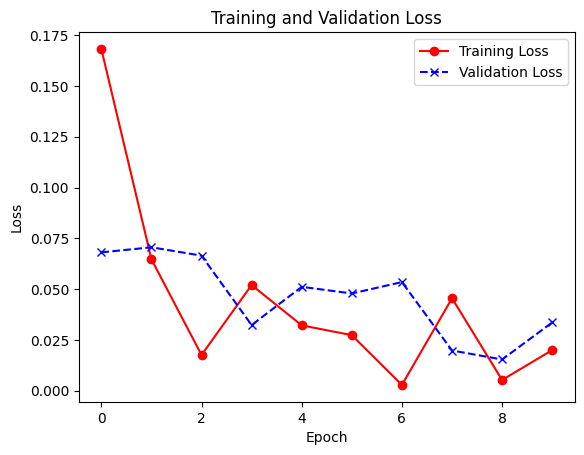

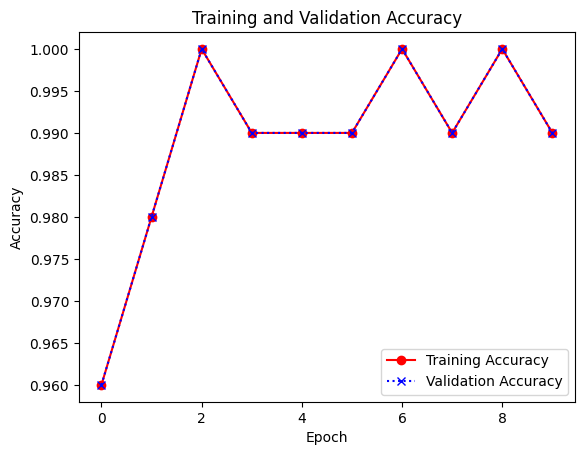

In [3]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over time
plt.plot(range(num_epochs),
		losses, color='red',
		label='Training Loss',
		marker='o')
plt.plot(range(num_epochs),
		val_losses,
		color='blue',
		linestyle='--',
		label='Validation Loss',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over time
plt.plot(range(num_epochs),
		accuracies,
		label='Training Accuracy',
		color='red',
		marker='o')
plt.plot(range(num_epochs),
		val_accuracies,
		label='Validation Accuracy',
		color='blue',
		linestyle=':',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [4]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.to('cpu')
        labels=labels.to('cpu')
        y_true.extend(labels)
        y_pred.extend(predicted)
print('Test Accuracy: {}%'.format(100 * correct / total))

Test Accuracy: 99.15%


In [5]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

